<a href="https://colab.research.google.com/github/hseghetto/PICME-Deep-Learning/blob/main/grow_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

#Loading dataset


In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

#(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [4]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

shape = train_images.shape
print(shape)

WIDTH = shape[-3]//4 #Smallest width to be used in generator, equivalente to 1/4 of the original image size
HEIGHT = shape[-2]//4
CHANNELS = shape[-1]

(60000, 28, 28, 1)


In [5]:
upsample = tf.keras.layers.UpSampling2D(size=(2,2))
downsample = tf.keras.layers.AveragePooling2D(pool_size=(2,2))

print(upsample(train_images[0:10]).shape)
print(downsample(train_images[0:10]).shape)

(10, 56, 56, 1)
(10, 14, 14, 1)


In [6]:
BUFFER_SIZE = 32000
BATCH_SIZE = 32
noise_dim = 100

# Batch and shuffle the data
train_dataset14 = tf.data.Dataset.from_tensor_slices(downsample(train_images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset28 = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset56 = tf.data.Dataset.from_tensor_slices(upsample(train_images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
class WeightedSum(tf.keras.layers.Add):
    # init with default value
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = tf.keras.backend.variable(alpha, name='ws_alpha')

    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        # ((1-a) * input1) + (a * input2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

#Model

##Generator

In [8]:
def generator_model():
    
    input_shape=(noise_dim,)
    input1 =  layers.Input(input_shape)

    x = layers.Dense(WIDTH*HEIGHT*16, use_bias = False)(input1)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((WIDTH,HEIGHT,16))(x)

    x = layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x) # 7x7x128 -> 14x14x128
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x) #to grayscale
    

    model = tf.keras.Model(input1,x)
    return model

In [9]:
def generator_expand(old_gen):
    
    input_shape=(noise_dim,)
    input1 =  layers.Input(input_shape)

    x = input1
    for old_layer in old_gen.layers[1:-1]:
        x = old_layer(x)
    
    x1 = old_gen.layers[-1](x)
    x1 = upsample(x1)
  
    x2 = layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU()(x2)

    x2 = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x2) # 14x14x64 -> 28x28x32
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU()(x2)

    x2 = layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x2)

    out = WeightedSum()([x1,x2])

    model_weighted = tf.keras.Model(input1,out)
    model = tf.keras.Model(input1,x2)
    return model_weighted, model

In [10]:
noise = tf.random.normal([1, 100])

gen = generator_model()
gen.summary()

new_gen,_ = generator_expand(gen)
new_gen.summary()

tf.keras.utils.plot_model(new_gen,to_file="gen_exp.png")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 784)               78400     
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 784)               0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 16)         6400      
 nspose)                                                     

Non-trainable params: 1,696
__________________________________________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


##Discriminator

In [11]:
def discriminator_model():
    input_shape = (WIDTH*2,HEIGHT*2,CHANNELS)
    input1 = layers.Input(input_shape, )

    x = layers.Conv2D(16, (5, 5), strides=(1, 1), padding='same')(input1)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(x) # 14x14x64 -> 7x7x64
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = tf.keras.Model(input1,x)
    return model

In [12]:
def discriminator_expand(old_disc):
    size = old_disc.input.shape[1]*2
    input_shape = (size,size,CHANNELS)

    input1 = layers.Input(input_shape)

    x = layers.Conv2D(16, (5, 5), strides=(1, 1), padding='same')(input1)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(x) # 28x28x64 -> 14x14x128
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x1 = downsample(input1)
    x1 = old_disc.layers[1](x1)
    x1 = old_disc.layers[2](x1)
    x1 = old_disc.layers[3](x1)

    x2 = WeightedSum()([x1,x])
    
    for old_layer in old_disc.layers[4:]:
        x2 = old_layer(x2)
        x = old_layer(x)

    model_weighted = tf.keras.Model(input1,x2)
    model = tf.keras.Model(input1,x)

    return model_weighted, model


In [13]:
disc = discriminator_model()
disc.summary()

new_disc,_ = discriminator_expand(disc)
new_disc.summary()

tf.keras.utils.plot_model(new_disc,to_file="disc_exp.png")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        416       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 16)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          6416      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 16)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 16)          0   

#Optimizer & Losses

In [14]:
#@tf.function
def generator_loss(fake_output):
    return tf.reduce_sum(fake_output)

In [15]:
#@tf.function
def discriminator_loss(real_output, fake_output, penalty = 0):
    return tf.reduce_sum(real_output - fake_output) + penalty

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-08)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-08)

#Training Loop

In [17]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
#@tf.function #cant use same tf function with different model shapes
def train_step_gp(images):
    noise = tf.random.normal([images.shape[0], noise_dim])
    e = tf.random.uniform([images.shape[0],1,1,1],minval = 0,maxval = 1)

    
    with tf.GradientTape(persistent=True) as tape:
        with tf.GradientTape() as penalty_tape:
            generated_images = generator(noise, training=True)
            print(generated_images.shape)
            weighted_images = e*images + (1-e)*generated_images

            weighted_output = discriminator(weighted_images, training = True)
        
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        penalty = penalty_tape.gradient(weighted_output,weighted_images) #gradient
        penalty = tf.sqrt(tf.reduce_sum(tf.square(penalty), axis=[1, 2, 3])) #norm
        penalty = 100*tf.reduce_mean(tf.math.square(penalty-1)) # k*(norm -1)^2

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, penalty)


    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def generate_and_save_images(epoch, test_input):
    predictions = generator(test_input, training = False)
    (examples, width, height, channels) = predictions.shape 
    
    mode = 'RGB'
    if channels==1:
        mode = 'L'
        predictions = np.squeeze(predictions)
        
    result = PIL.Image.new(mode,(4*width,4*height))
    
    for i in range(min(16,examples)):
        image = np.array((predictions[i]*127.5+127.5)).clip(0,255).squeeze().astype("uint8")
        image = PIL.Image.fromarray(image,mode)
        result.paste(im=image,box=(width*(i//4),height*(i%4)))
    
    result.save('pg_gan/nn_{}_step_{}_epoch_{:04d}.png'.format(NN,TRAIN,epoch),"PNG")
    plt.imshow(np.asarray(result),cmap="gray")
    plt.show()

In [21]:
def train(dataset,Epochs):

    print("Starting training")
    for epoch in range(Epochs):
        start = time.time()

        #print("Epoch {}".format(epoch+1))

        for image_batch in dataset:
            #print(".",end="")
            train_step_gp(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(epoch + 1,seed)
        
        print ("Time for epoch {}/{} is {} sec".format(epoch + 1,Epochs, time.time()-start))

In [22]:
def train_fade_in(dataset,Epochs):

    print("Starting training with fade-in")
    for epoch in range(Epochs):
        start = time.time()
        #print("Epoch {}".format(epoch+1))

        alpha = (epoch+1)/Epochs #0 to 1
        for image_batch in dataset:
            #print(".",end="")
            for layer in discriminator.layers:
                if isinstance(layer,WeightedSum):
                    tf.keras.backend.set_value(layer.alpha,alpha)
            for layer in generator.layers:
                if isinstance(layer,WeightedSum):
                    tf.keras.backend.set_value(layer.alpha,alpha)
            
            train_step_gp(image_batch)


        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(epoch + 1,seed)
        
        print ("Time for epoch {}/{} is {} sec".format(epoch + 1,Epochs, time.time()-start))

### Testing

(1, 4, 4, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


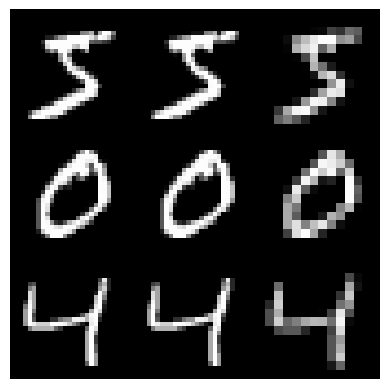

Wall time: 114 ms


In [23]:
%%time
for i in range(10):
    image = tf.random.normal([1,2,2,1])
    upsize = upsample(image)
print(upsize.shape)
print(type(upsize))
print(type(image))

(width,height,channels) = train_images[0].shape
mode = 'RGB'
if channels==1:
    mode = 'L'
result = PIL.Image.new(mode,(3*width,3*height))

for i in range(3):
    image = downsample(upsample(train_images[i:i+1]))
    image = np.array((image*127.5+127.5)).clip(0,255).squeeze().astype("uint8")
    image = PIL.Image.fromarray(image,mode)
    result.paste(im=image,box=(width*0,height*i))
    
    image = train_images[i:i+1]
    image = np.array((image*127.5+127.5)).clip(0,255).squeeze().astype("uint8")
    image = PIL.Image.fromarray(image,mode)
    result.paste(im=image,box=(width*1,height*i))
    
    image = upsample(downsample(train_images[i:i+1]))
    image = np.array((image*127.5+127.5)).clip(0,255).squeeze().astype("uint8")
    image = PIL.Image.fromarray(image,mode)
    result.paste(im=image,box=(width*2,height*i))

plt.imshow(np.asarray(result),cmap="gray")
plt.axis("off")
plt.show()

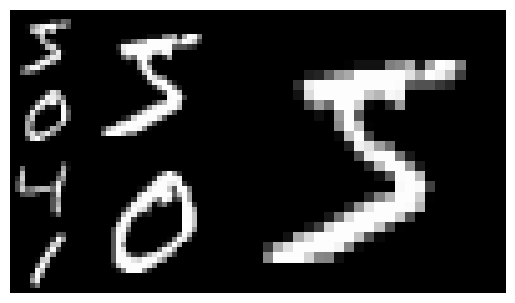

In [24]:
(width,height,channels) = train_images[0].shape
mode = 'RGB'
if channels==1:
    mode = 'L'
result = PIL.Image.new(mode,(int(3.5*width),2*height))

for i in range(4):
    image = downsample(train_images[i:i+1])
    image = np.array((image*127.5+127.5)).clip(0,255).squeeze().astype("uint8")
    image = PIL.Image.fromarray(image,mode)
    result.paste(im=image,box=(width*0,int(height*i/2)))
    
for i in range(2):
    image = train_images[i:i+1]
    image = np.array((image*127.5+127.5)).clip(0,255).squeeze().astype("uint8")
    image = PIL.Image.fromarray(image,mode)
    result.paste(im=image,box=(int(width/2),height*i))

i=0
image = upsample(train_images[i:i+1])
image = np.array((image*127.5+127.5)).clip(0,255).squeeze().astype("uint8")
image = PIL.Image.fromarray(image,mode)
result.paste(im=image,box=(int(width*3/2),0))

plt.imshow(np.asarray(result),cmap="gray")
plt.axis("off")
plt.show()

#Model training

In [25]:
try:
    NN = NN + 1
except:
    og_train_step = train_step_gp
    NN = 0

In [26]:
try:
    os.mkdir("pg_gan")
except:
    pass

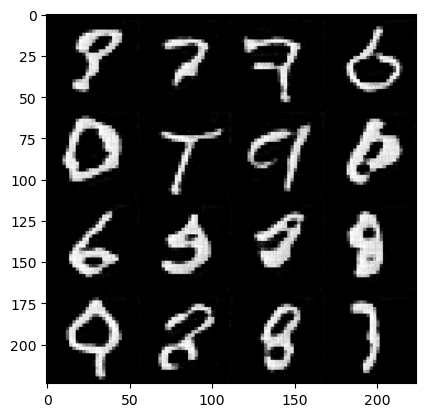

Time for epoch 20/20 is 55.989200592041016 sec


In [27]:
NN = NN +1
TRAIN = 0

train_step_gp = tf.function()(og_train_step)

generator = generator_model()
discriminator = discriminator_model()

train(train_dataset14,20)
TRAIN = TRAIN+1

generator,g = generator_expand(generator)
discriminator,d = discriminator_expand(discriminator)

train_step_gp = tf.function()(og_train_step)

train_fade_in(train_dataset28,20)
TRAIN = TRAIN+1

train(train_dataset28,20)
TRAIN = TRAIN+1

generator,g = generator_expand(g)
discriminator,d = discriminator_expand(d)

train_step_gp = tf.function()(og_train_step)

train_fade_in(train_dataset56,20)
TRAIN = TRAIN+1

train(train_dataset56,20)
TRAIN = TRAIN+1

In [29]:
fp_in = "pg_gan/nn_{}*.png".format(NN)
fp_out = "pg_gan/nn_{}_scaled.gif".format(NN)

img, *imgs = [PIL.Image.open(f) for f in sorted(glob.glob(fp_in))]

img = img.resize(imgs[-1].size, PIL.Image.ANTIALIAS)
for i in range(len(imgs)):
    imgs[i] = imgs[i].resize(imgs[-1].size, PIL.Image.ANTIALIAS)

img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)

C:\Users\hss19\AppData\Local\Temp\ipykernel_6708\3450863758.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(imgs[-1].size, PIL.Image.ANTIALIAS)
C:\Users\hss19\AppData\Local\Temp\ipykernel_6708\3450863758.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imgs[i] = imgs[i].resize(imgs[-1].size, PIL.Image.ANTIALIAS)


In [30]:
fp_in = "pg_gan/nn_{}*.png".format(NN)
fp_out = "pg_gan/nn_{}_real.gif".format(NN)

imgs = [PIL.Image.open(f) for f in sorted(glob.glob(fp_in))]

result = PIL.Image.new("RGB", imgs[-1].size, (0,0,0))
for i in range(len(imgs)):
    x = int(result.size[0]/2-imgs[i].size[0]/2)
    y = int(result.size[1]/2-imgs[i].size[1]/2)
    
    aux = imgs[i].copy()
    imgs[i] = result.copy()
    imgs[i].paste(aux,box=(x,y))

result.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)